In [11]:
import numpy as np
import torch as torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.linear_model import LinearRegression
import random as random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import sys

sys.path.append('../Package')
import PD
import Normalizer
import Weighted_MSE
import Dataset_c

In [12]:
def train_weighted(model, criterion, train_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = []

    for epoch in range(epochs):
        #for i, (x, y) in enumerate(train_loader):
            #model.train()
            #optimizer.zero_grad()
            #z = model(x.view(-1, np.shape(x)[1]))
            #y = y.float()
            #loss = criterion(z, y)
            #loss.backward()
            #optimizer.step()
        for i, (x, y, w) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, np.shape(x)[1]))
            y = y.float()
            loss = criterion(z, y, w)
            loss.backward()
            optimizer.step()
            
        if epoch % 50 == 0 and epoch > 1 :
            z_test = model(torch.tensor(Normalized_in_test))
            #z_test = model(torch.tensor(input_test))
            plt.scatter(u_test, Normalizer_out.inverse_normalize(z_test.detach()))
            #plt.scatter(u_test, z_test.detach())
            print(f"Epoch {epoch + 1}/{epochs}, Training loss: {loss.item()}")
        useful_stuff.append(loss.data.item())

    # plt.plot(useful_stuff)

    return useful_stuff

In [13]:
class Net(nn.Module):

    def __init__(self, in_size, n_hidden1, n_hidden2,n_hidden3, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, out_size)

    # Prediction

    def forward(self, x):
        x = x.float()
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        x = self.linear4(x)
        return x
    # Activations, to analyze results

    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.tanh(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.tanh(z2).double()
        out.append(a2.detach().numpy().reshape(-1))
        z3 = self.linear3(a2)
        out.append(z3.detach().numpy().reshape(-1))
        a3 = torch.tanh(z3)
        out.append(a3.detach().numpy().reshape(-1))
        return out
    

In [14]:
#Set up the data and parameters
viscos = 1 / 5200
#load data
# Read y
datay = np.loadtxt("../data/sparse/y2d.dat")

yp_wall = datay[1] / 2
y0 = 2 * yp_wall
yp_first_cell = np.loadtxt('../data/sparse/yp-instant-IDDES.dat')
# Read local vel
u_first_cells_local = np.loadtxt('../data/sparse/u-instant-IDDES-hist.dat')
u_wall = u_first_cells_local[:, 0]
ustar = (viscos * np.abs(u_wall) / yp_wall) ** 0.5

In [15]:
##Height of the physical domain
h_phs=2
##Viscosity of the physical domain
nu_phys=1/5200
###Physical velocity of the main stream
u_phs=24.35
##LB parameters of the physical domain
h_lb=60
x_length=600
dx=h_phs/h_lb
tau_lb=0.5000378
cs2=1/3
nu_lb=cs2*(tau_lb-0.5)
dt=nu_lb/nu_phys*dx**2
LB_configuration=[dt,dx]
print("dt=",dt)
print("dx=",dx)
print('nu_lb=',nu_lb)

dt= 7.27999999999552e-05
dx= 0.03333333333333333
nu_lb= 1.2599999999992246e-05


In [16]:
class Converter:

    def __init__(self, LB_configuration):
        (self.dt,self.dx) = LB_configuration
        

    def Phy2LB_u(self,u_dns):
        u_lb=u_dns*self.dt/self.dx
        return u_lb
    
    def Phy2LB_y(self,y_dns):
        y_lb=y_dns/self.dx
        return y_lb

    def LB_u2Phy(self,u_lb):
        u_phy=u_lb*self.dx/self.dt
        return u_phy
   
    def LB_y2Phy(self,y_lb):
        y_phy=y_lb*self.dx
        return y_phy

In [17]:
converter=Converter(LB_configuration)

In [18]:
Index_sampledown = np.random.choice(range(len(u_first_cells_local)), 1500)
# Specify the number of samples and layers of samples to train
u_lowL = 2
u_uppeerL = 9
u_sampled = u_first_cells_local[Index_sampledown, u_lowL:u_uppeerL]
ustar_sampled = ustar[Index_sampledown]
#gradient=(u_sampled[:,1]-u_sampled[:,0])/(yp_first_cell[1]-yp_first_cell[0])
#gradient_n=gradient*viscos/u_sampled[:,0]
#gradient_n=gradient
#gradient_replicated=np.tile(gradient_n,(np.shape(u_sampled)[1],1))
#np.shape(gradient_replicated)
#gradient_replicated=gradient_replicated.T
#ustar_sampled = ustar_sampled[Index_sampledown]
#uplus = u_sampled[:, 0:9] / ustar_sampled[:, np.newaxis]
y_sampled = np.tile(yp_first_cell[u_lowL-1:u_uppeerL-1], (len(Index_sampledown), 1))
replicated_ustar = np.tile(ustar_sampled.reshape(-1,1) , (1,np.shape(u_sampled)[1]))
#yplus = np.tile(yp_first_cell, (len(Index_sampledown), 1))
#yplus = yplus[:, :9] / viscos * ustar_sampled[:, np.newaxis]
u_flat = u_sampled.reshape(-1, 1)
y_flat = y_sampled.reshape(-1, 1)
u_lbm=converter.Phy2LB_u(u_flat)
y_lbm=converter.Phy2LB_y(y_flat)
ustar_lbm=converter.Phy2LB_u(ustar_sampled)
replicated_ustar_lbm = np.tile(ustar_lbm.reshape(-1, 1), (1, np.shape(u_sampled)[1]))
replicated_ustar_lbm = replicated_ustar_lbm.reshape(-1, 1)
y_ref=1/5200/dx
#gradient_input=gradient_replicated.reshape(-1, 1)

In [19]:
def feature_builder(u, y):
    input1 = np.divide(np.abs(u), y) /dt/1000
    input2 = np.divide(np.log(y / y_ref), np.abs(u)*dx/dt)
    #input3=gradient
    return input1, input2


(feature1, feature2) = feature_builder(u_lbm, y_lbm )

In [20]:
Input_1=feature1.reshape(-1, 1)
Input_2=feature2.reshape(-1, 1)
#Input_3=feature3.reshape(-1, 1)
Input_file=np.concatenate((Input_1, Input_2), axis=1)
#Input_file=np.concatenate((Input_1, Input_2), axis=1)
Output_file=replicated_ustar.reshape(-1, 1)

In [21]:
print('input1_max=',np.max(Input_1))
print('input2_min=',np.min(Input_1))
print('input2_max=',np.max(Input_2))
print('input2_min=',np.min(Input_2))

input1_max= 3.4179129452476054
input2_min= 0.46057869293791265
input2_max= 0.3682174453074544
input2_min= 0.16848909163388875


In [22]:
Height_to_visualize =7
u_test = u_first_cells_local[Index_sampledown, Height_to_visualize].reshape(-1, 1)
y_test = np.tile(yp_first_cell[Height_to_visualize], (len(Index_sampledown), 1))
#gradient_test=gradient_n
u_lbm_test=converter.Phy2LB_u(u_test)
y_lbm_test=converter.Phy2LB_y(y_test)
(feature_test_1, feature_test_2) = feature_builder(u_lbm_test, y_lbm_test)
input_test_1 = feature_test_1
input_test_2 = feature_test_2
#input_test_3 = feature_test_3
input_test = np.concatenate((input_test_1, input_test_2), axis=1)

In [23]:
Normalizer_in = Normalizer.MinMaxNormalizer(Input_file)
Normalizer_out = Normalizer.MinMaxNormalizer(Output_file)
#MinMaxNormalizer do norm for each row
Normalized_in = Normalizer_in.min_max_normalize()
Normalized_out = Normalizer_out.min_max_normalize()
Normalized_in_test = Normalizer_in.normalize(input_test)
PDF = PD.PD_function(Normalized_in, 0.02)
map = PDF.generate_function()


In [24]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, input_file, output_file):
        self.input_file = input_file
        self.output_file = output_file

    def __len__(self):
        return len(self.input_file)

    def __getitem__(self, index):
        return self.input_file[index], self.output_file[index]

In [25]:
#Configure train and test
model = Net(np.shape(Input_file)[1], 9,8, 5, np.shape(Output_file)[1])
#criterion = nn.MSELoss()
criterion = Weighted_MSE.WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [27]:
#X_trainval, X_test, y_trainval, y_test = train_test_split(Input_file, Output_file, test_size=0.2, random_state=42)
X_trainval, X_test, y_trainval, y_test = train_test_split(Normalized_in , Normalized_out, test_size=0.2, random_state=42)
pdf_train=PDF.calculation(X_trainval)
epsilon=1e-5
weight_train=1/(pdf_train+epsilon)
weight_train=weight_train.reshape(-1,1)
weight_train=weight_train/weight_train.min()
#train_loader=torch.utils.data.DataLoader(MyDataset(X_trainval,y_trainval), batch_size=20, shuffle=True)
train_loader=torch.utils.data.DataLoader(Dataset_c.MyDataset_weighted(X_trainval,y_trainval,weight_train), batch_size=20, shuffle=True)

Epoch 51/300, Training loss: 0.05477442369858894
Epoch 101/300, Training loss: 0.054130583936944456
Epoch 151/300, Training loss: 0.11258814550170815
Epoch 201/300, Training loss: 0.03160064448113038
Epoch 251/300, Training loss: 0.052968008669009234


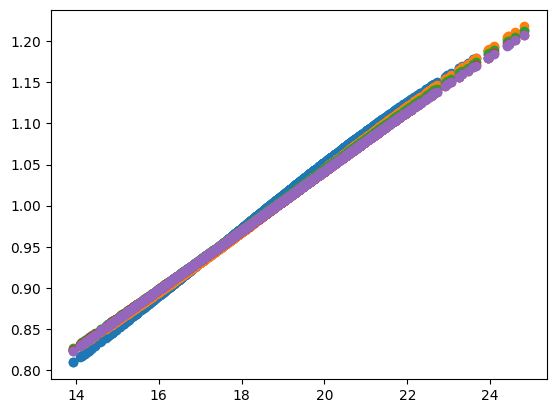

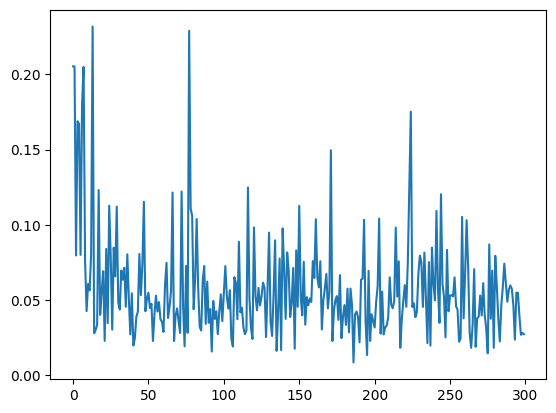

In [28]:
loss = train_weighted(model, criterion, train_loader, optimizer, 300)
figure = plt.figure()
plt.plot(loss)

In [29]:
Index_test = np.random.choice(range(len(u_first_cells_local)), 320)
Height_to_visualize =5
u_test = u_first_cells_local[Index_test, Height_to_visualize]
y_test = np.tile(yp_first_cell[Height_to_visualize], (len(Index_test), 1))
u_lbm_test=converter.Phy2LB_u(u_test)
y_lbm_test=converter.Phy2LB_y(y_test)
ustar_sampled_test = ustar[Index_test]
ustar_lbm_test=converter.Phy2LB_u(ustar_sampled_test)
(feature_test_1, feature_test_2) = feature_builder(u_lbm_test.reshape(-1, 1), y_lbm_test)
input_test_1 = feature_test_1
input_test_2 = feature_test_2
#input_test_3 = feature_test_3
input_test = np.concatenate((input_test_1, input_test_2), axis=1)
Normalized_in_test = Normalizer_in.normalize(input_test)
z_test=model(torch.tensor(Normalized_in_test))
ustar_lbm=converter.Phy2LB_u(ustar_sampled_test)

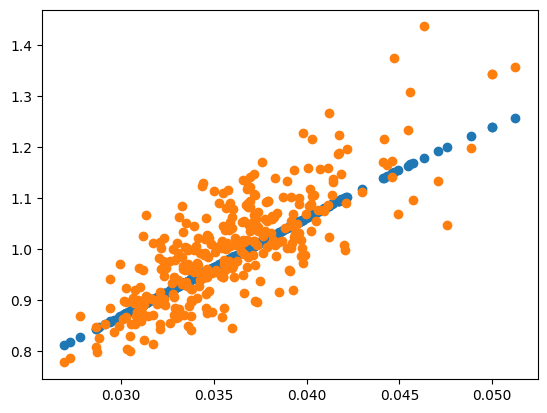

In [31]:
np.shape(ustar_sampled)
plt.figure()
plt.scatter(u_lbm_test,Normalizer_out.inverse_normalize(z_test.detach()))
plt.scatter(u_lbm_test,ustar_sampled_test)

In [33]:
input_data=torch.randn(1, 2)
import os
os.chdir('C:\\Users\\ffyrt\\PycharmProjects\\pythonProject4\\gitdir\\pinns_paper\\Model\\upyp_sparse')
traced_model = torch.jit.trace(model, input_data)

torch.jit.save(traced_model, "model_lbm_sparse_PDF_1.pt")